In [2]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import os
from scipy.optimize import Bounds, minimize
from scipy import optimize
from airfoils import Airfoil
import matplotlib.animation as animation
from IPython.display import HTML, Image
plt.rc('text', usetex=True)
%matplotlib notebook

# Optimization

In [3]:
def numerical_gradient(f, X, h=0.001):
    x,y = X
    grad_fx = (f([x+h,y])-f([x-h,y]))/2*h
    grad_fy = (f([x,y+h])-f([x,y-h]))/2*h
    return np.array([grad_fx, grad_fy])

In [4]:
def test_function(x):
    z = (x[0]**2+x[1]-11)**2 + (x[0]+x[1]**2-7)**2
    return z

compute function in multiple points of space to plot it

In [5]:
domainXY = [[-5,5],[-5,5]]
n        = 100
x1, x2   = np.meshgrid(np.linspace(domainXY[0][0], domainXY[0][1], n), np.linspace(domainXY[1][0], domainXY[1][1], n))
x_grid   = np.vstack([x1.ravel(), x2.ravel()])
Z        = test_function(x_grid).reshape(n,n)

In [6]:
plt.contour(x1, x2, Z, levels=40, cmap='jet')

<IPython.core.display.Javascript object>

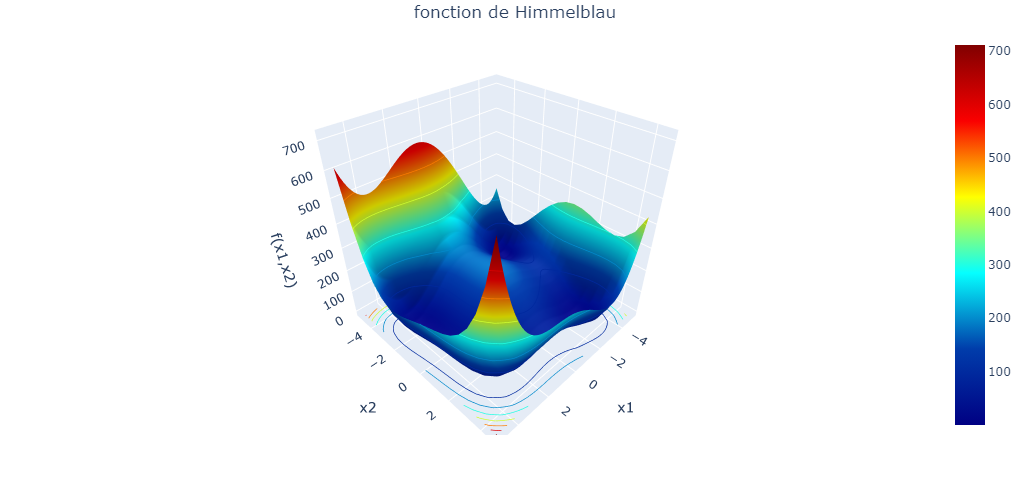

In [25]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=x1[::5],y=x2[::5],z=Z[::5])])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, project_z=True), colorscale="jet")
fig.update_layout(autosize=False, width=500, height=500,margin=dict(l=65, r=50, b=65, t=35),title_text="fonction de Himmelblau", title_x=0.5)
fig.update_layout(scene = dict(xaxis_title='x1',yaxis_title='x2',zaxis_title='f(x1,x2)'))
fig.show()
fig.write_html("himmelblau.html")

## Gradient Descent
$$ x_{k+1} = x_k - \alpha \nabla f(x_k) $$

In practice, it works if you have the analytic gradient because numerical gradient is too inaccurate and can easily explode. Also, it could be expensive as it needs to evaluate $f$

In [7]:
def gradient(f, x0, param=0.01, itermax=1000):
    # parameters
    alpha = param
    # initialization
    x  = np.zeros((itermax+1, len(x0)))
    fx = np.zeros((itermax+1, 1))
    x[0,:] = x0
    fx[0] = f(x0)
    # iterative loop
    k = 0
    while (k < itermax):
        grad_fxk = numerical_gradient(f, x[k,:], h=0.1)
        x[k+1,:] = x[k,:] - alpha * grad_fxk
        fx[k+1]  = f(x[k+1,:])
        k = k+1
    return x[:k+1,:]

<IPython.core.display.Javascript object>


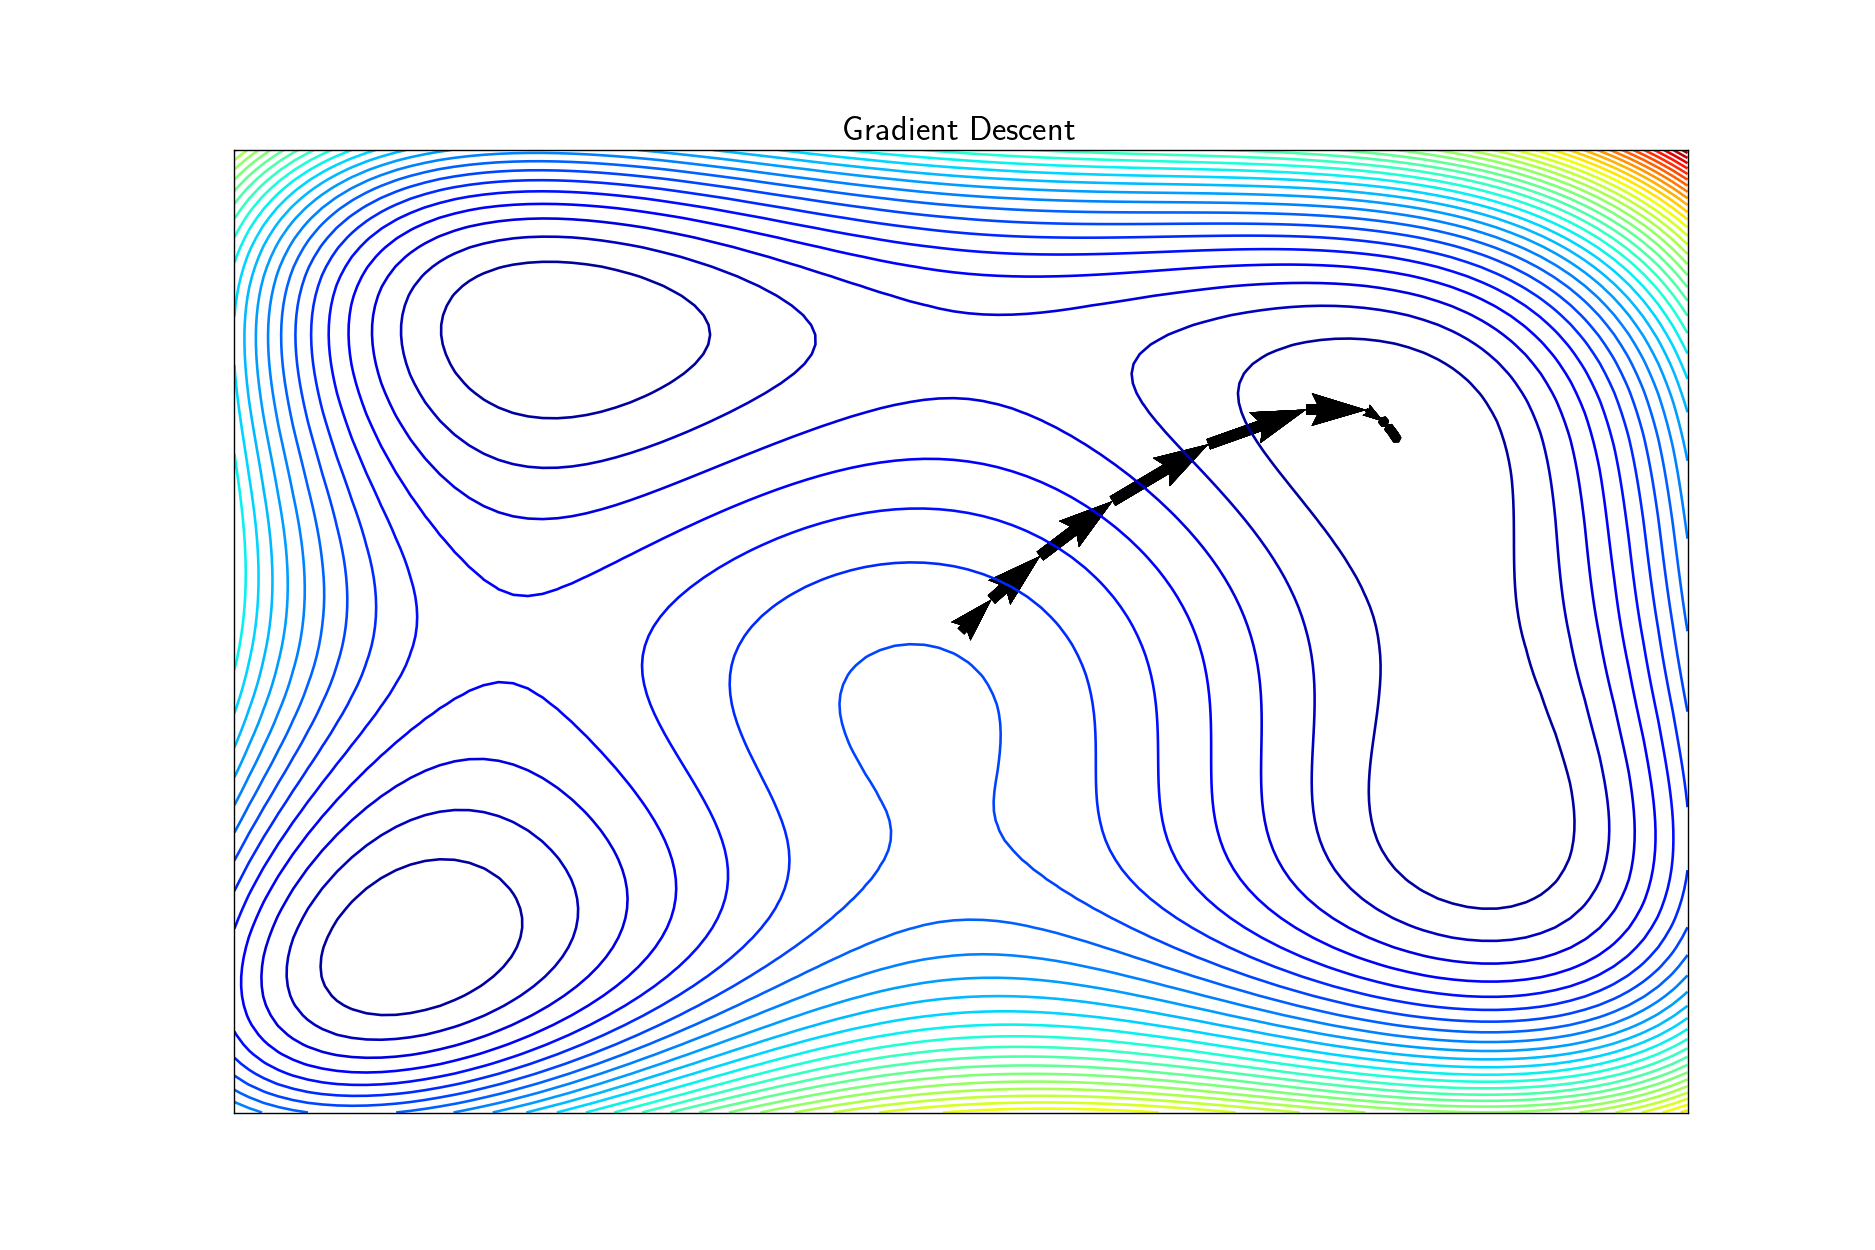

In [8]:
X = gradient(test_function, x0=[0,0], param=1.5, itermax=15)
# display
fig, ax  = plt.subplots(figsize=(15,10))
plt.contour(x1, x2, Z, levels=40, cmap='jet')
plt.xticks(()), plt.yticks(()), plt.title("Gradient Descent", fontsize=20)
for i in np.arange(1,len(X)):  #scale_units='xy', angles='xy',
    plt.quiver(X[:i-1,0], X[:i-1,1], X[1:i,0]-X[:i-1,0], X[1:i,1]-X[:i-1,1], scale_units='xy', angles='xy', scale=1, color='k')
    fig.savefig(str(i)+'.png', bbox_inches='tight')
plt.show()

## Evolution Strategy
It is a statiscal method so proof of convergence is also statistical. One of the advantage is that it solve global minimization (unlike other that are for local minimum), but a drawback is that it requires a lot of evaluation of the cost function

In [9]:
def evolution_strategy(f, x0, params=[5,3,1], itermax=1000):
    # parameters
    dim = len(x0)
    lambd, mu, tau = params
    # initialization
    x      = np.zeros((itermax+1, dim))
    xp     = np.zeros((itermax+1, lambd, dim))
    s      = np.zeros((itermax+1, dim))
    x[0,:] = x0
    s[0,:] = [0.1,0.1]
    # ITERATIVE LOOP
    k = 0
    while (k < itermax):
        # GENERATION
        sp = s[k,:] * np.exp(tau * randn(lambd, dim))
        xp[k,:,:] = x[k,:] + sp * randn(lambd, dim)
        Zp = [f(xi) for xi in xp[k,:,:]]
        # SELECTION
        mins = np.argsort(Zp)[:mu]
        xc   = xp[k,mins,:]
        sc   = sp[mins,:]
        # UPDATE
        x[k+1,:] = np.mean(xc, 0)
        s[k+1,:] = np.mean(sc, 0)
        k = k+1
    return x[:k+1,:], xp[:k+1,:,:]

<IPython.core.display.Javascript object>


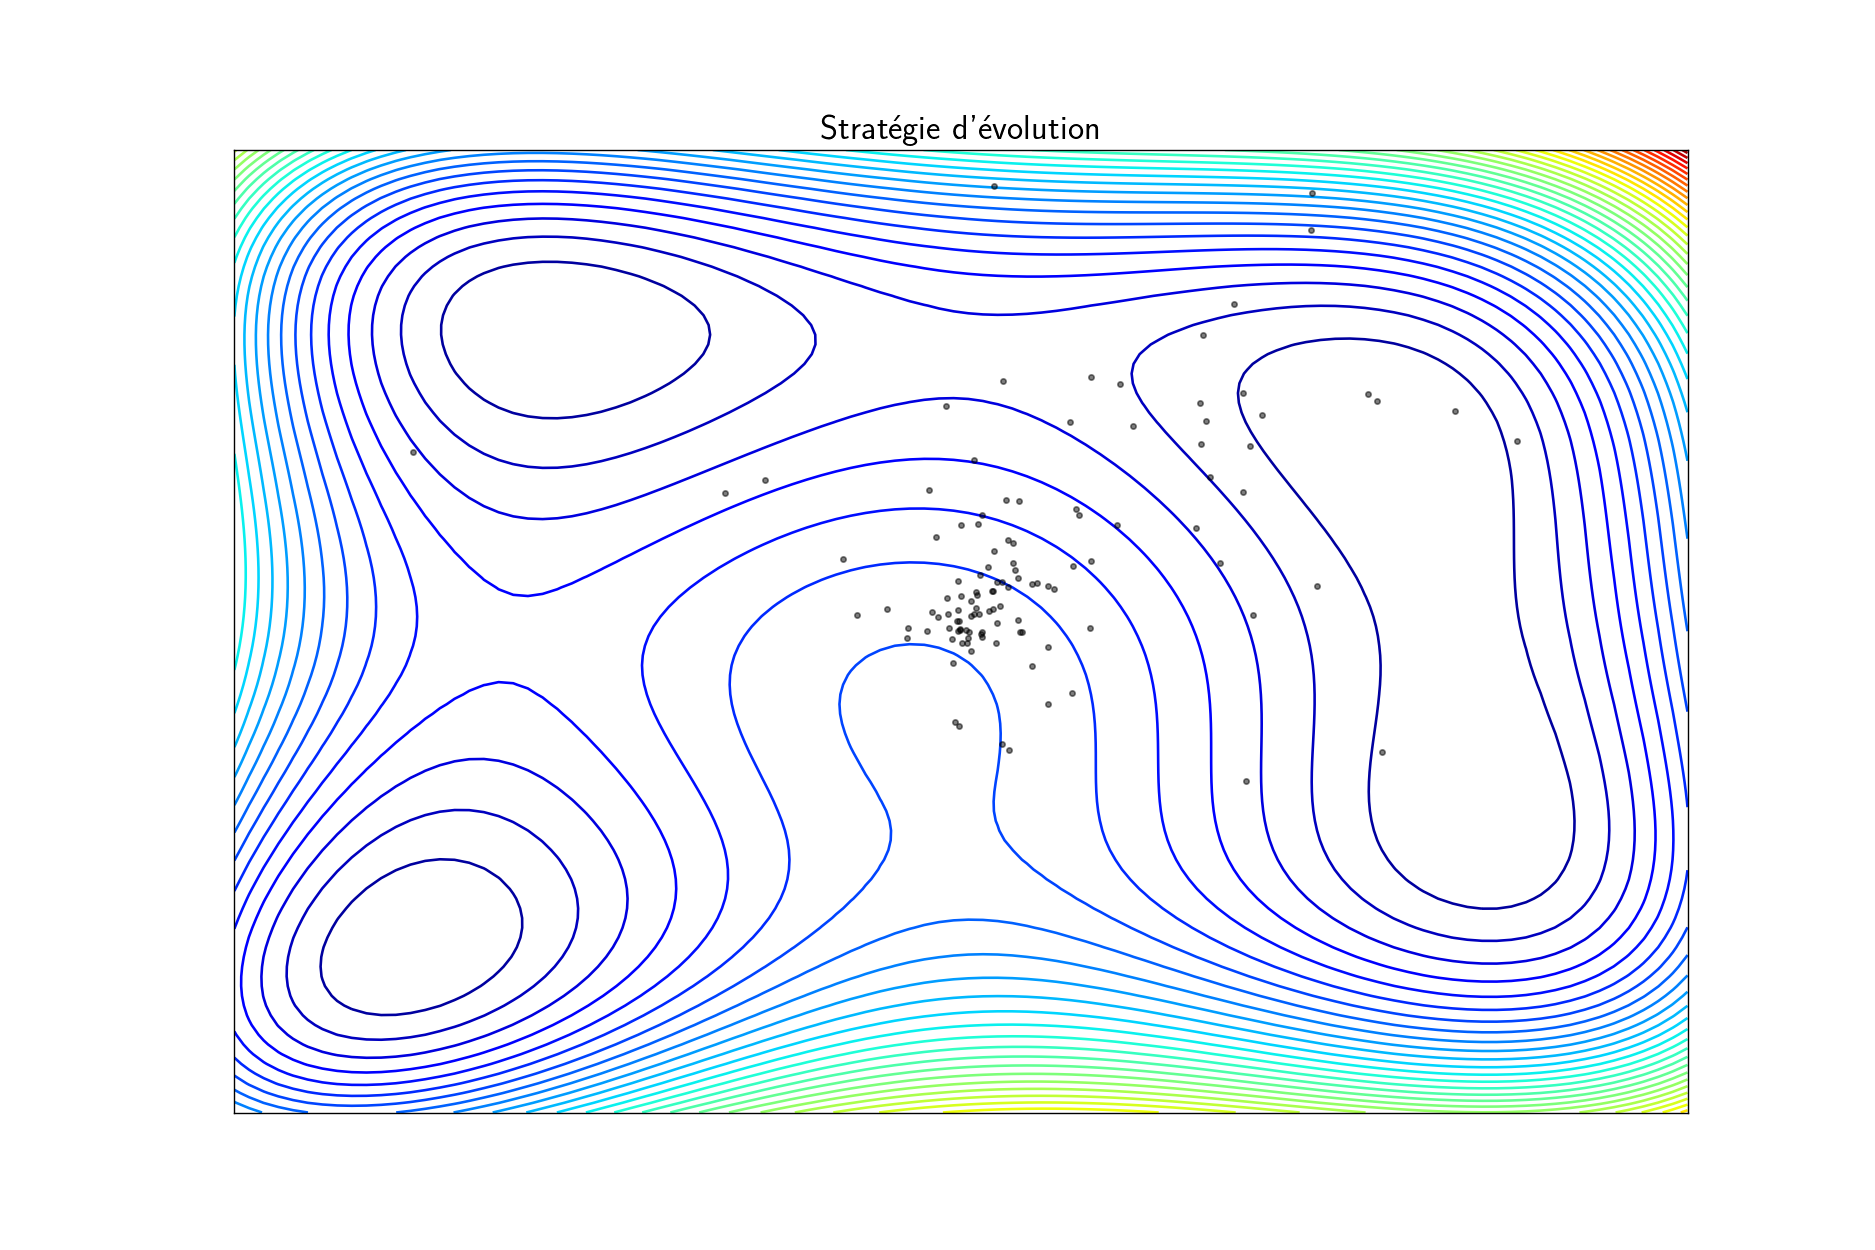

In [139]:
X, xc = evolution_strategy(test_function, x0=[0,0], params=[20,5,1], itermax=25)
# display
fig, ax = plt.subplots(figsize=(15,10))
plt.contour(x1, x2, Z, levels=40, cmap='jet')
plt.xticks(()), plt.yticks(()), plt.title("Stratégie d'évolution", fontsize=20)
line1, = ax.plot([],[],'ko')
line2, = ax.plot([],[],'k.',alpha=0.5)
def init():
    line1.set_data([],[])
    line2.set_data([],[])
    return line1, line2
# animate
def animate(i): 
    line1.set_data(X[:i,0], X[:i,1])
    line2.set_data(xc[:i,:,0].reshape(i*20), xc[:i,:,1].reshape(i*20))
    return line1, line2
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(X), blit=True, interval=1000, repeat=True)
plt.show()
ani.save(r"evolution_strategy.gif", writer='imagemagick')

## Nelder-Mead Method
It is an algorithm that find local minimum but does not requires do compute the gradient of the cost function

In [29]:
def nelder_mead(f, x0, params=2, itermax=1000):
    c = params   
    # initialization
    x1, x2, x3 = np.array([[x0[0]-0.5,x0[1]],[x0[0],x0[1]],[x0[0],x0[1]+0.5]])
    x  = np.array([x1, x2, x3])
    xm = np.zeros((itermax+1, len(x0)))
    triangles = np.zeros((itermax+1, 3, len(x0)))
    triangles[0,:,:] = x
    xm[0,:] = x0
    # iterative loop
    k = 0
    while (k < itermax):
        # SORT SIMPLEX
        A = f(x.T)
        index = np.argsort(A) 
        x_min, x_max, x_bar = x[index[0],:], x[index[2],:], (x[index[0],:] + x[index[1],:])/2
        # REFLECTION
        x_refl = x_bar + (x_bar - x_max)
        # EXPANSION
        if f(x_refl) < f(x_min): 
            x_exp = x_bar + 2*(x_bar - x_max)
            if f(x_exp) < f(x_refl):
                x_max = x_exp
            else:
                x_max = x_refl
        elif (f(x_min) < f(x_refl)) and (f(x_refl) < f(x_max)):
            x_max = x_refl 
        # CONTRACTION
        else: 
            x_con = x_bar - (x_bar - x_max)/2
            if f(x_con) < f(x_min):
                x_max = x_con
            else:
                x[index[1],:] = x_max + (x[index[1],:] - x_min)/2
        # UPDATE DATAs
        x = np.array([x_max, x[index[1],:], x_min])
        xm[k+1,:] = x_bar
        triangles[k+1,:,:] = x
        k = k+1
    return xm[:k+1,:], triangles[:k+1,:]

<IPython.core.display.Javascript object>


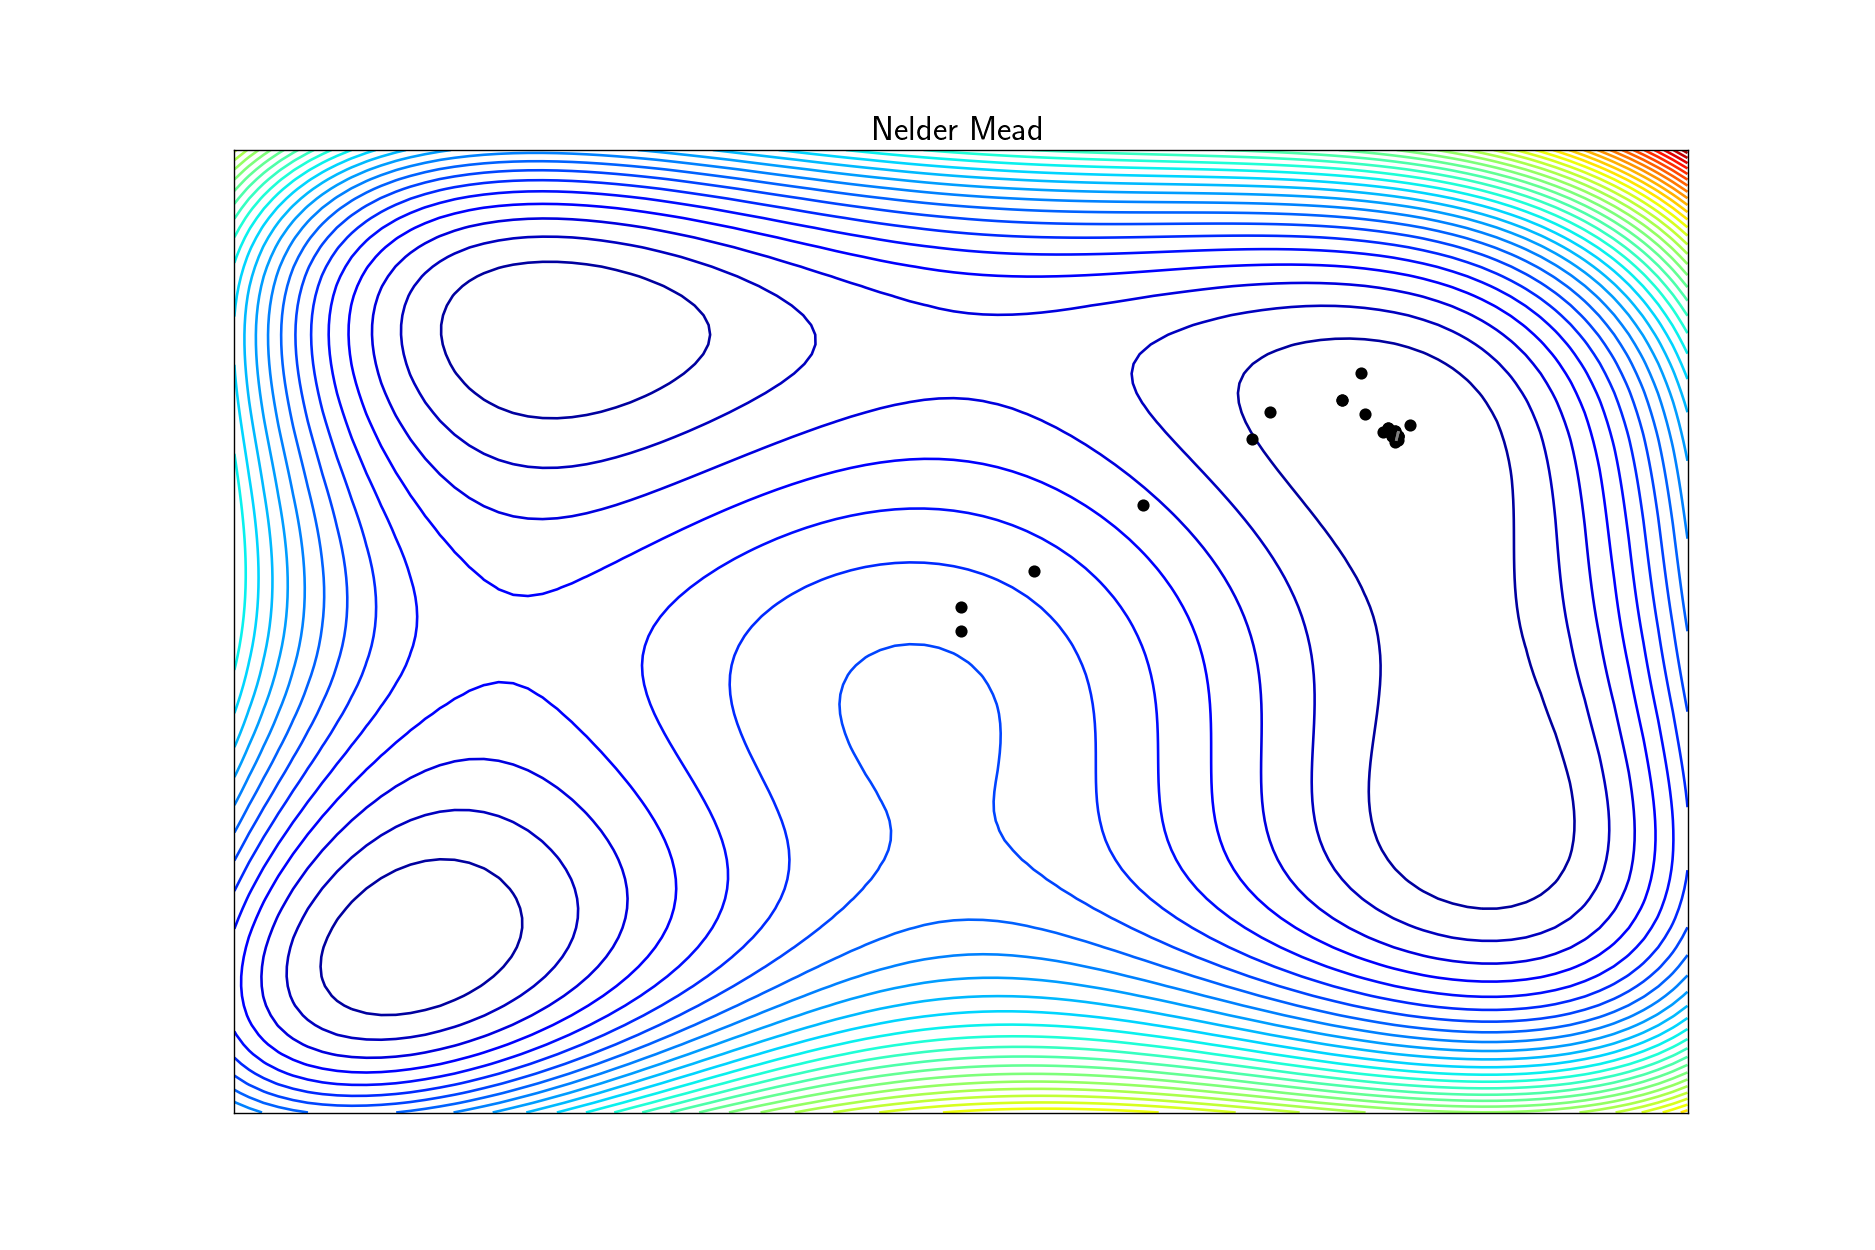

In [36]:
X, triangles = nelder_mead(test_function, x0=[0,0], params=1, itermax=30)
# display
fig, ax = plt.subplots(figsize=(15,10))
plt.contour(x1, x2, Z, levels=40, cmap='jet')
plt.xticks(()), plt.yticks(()), plt.title("Nelder Mead", fontsize=20)
line1, = ax.plot([],[],'ko')
triangle1, = ax.plot([],[],'gray')
triangle2, = ax.plot([],[],'gray')
triangle3, = ax.plot([],[],'gray')
def init():
    line1.set_data([],[])
    triangle1.set_data([],[])
    triangle2.set_data([],[])
    triangle3.set_data([],[])
    return line1, triangle1, triangle2, triangle3
# animate
def animate(i): 
    line1.set_data(X[:i+1,0], X[:i+1,1])
    triangle1.set_data([triangles[i,0,0],triangles[i,1,0]], [triangles[i,0,1],triangles[i,1,1]])
    triangle2.set_data([triangles[i,0,0],triangles[i,2,0]], [triangles[i,0,1],triangles[i,2,1]])
    triangle3.set_data([triangles[i,2,0],triangles[i,1,0]], [triangles[i,2,1],triangles[i,1,1]])
    return line1,  triangle1, triangle2, triangle3
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(X), blit=True, interval=1000, repeat=True)
plt.show()
ani.save(r"nelder_mead.gif", writer='imagemagick')

# Aerodynamism problem

## XFOIL interface

In [11]:
def read_xfoil():
    with open("results.dat", "r") as file:
        coeffs = file.readlines()[-1]
    CL = float(coeffs.split()[1])
    CD = float(coeffs.split()[2])
    return CL, CD

def write_xfoil(x):
    NACAx, NACAy  = int(x[0]), int(x[1])
    NACAep, alpha = int(x[2]), x[4]
    c    = (1/10)*x[3]
    mach = 12/340
    # write command in file
    file = open("input.dat", "w")
    file.write("plop\ng\n\n")
    file.write("naca "+str(NACAx)+str(NACAy)+str(NACAep)+"\n\noper\n")
    file.write("mach "+str(mach)+"\n")
    file.write("visc "+str(c*12./(1.8*10e-5))+"\n")
    file.write("pacc\nresults.dat\ny\n\n")
    file.write("alfa "+str(alpha)+"\n\nquit")
    file.close()

In [12]:
if 'XFOIL6.99' not in os.getcwd():
    os.chdir('XFOIL6.99')
# write input file
write_xfoil([2,5,15,5,5])
# run XFOIL
os.system(r'xfoil.exe < input.dat')

0

## Optimization

In [13]:
# constantes
poids = 6
Ro    = 1
V     = 12
# function to minimize
def cost_function(x):
    # call xfoil
    write_xfoil(x)
    os.system(r'xfoil.exe < input.dat')
    CL, CD = read_xfoil()
    # compute COST function
    L  = x[3]
    c  = (1/10)*L
    S  = L*c
    Fx = 0.5*Ro*S*V**2*CD
    Fy = 0.5*Ro*S*V**2*CL
    y  = Fx + max(0, poids-Fy)
    return y

In [14]:
x_history, f_history = [], []
def callback_history(x, f, context):
    x_history.append(x)
    f_history.append(f)
    
x0 = np.array([2, 4, 12, 5, 5])
bounds_2 = [(0,4),(2,8),(10,20),(2,6),(0,10)]
optimize.dual_annealing(cost_function, bounds_2, x0=x0, maxiter=10, callback=callback_history)

KeyboardInterrupt: 

## display NACA profil

In [ ]:
%matplotlib notebook

In [ ]:
N = len(f_history)
# initialization
fig, ax     = plt.subplots(1,2,figsize=(30,10))
line_upper, = ax[0].plot([],[],'tab:blue')
line_lower, = ax[0].plot([],[],'tab:blue')
line_cost,  = ax[1].plot([],[],'ro-')
ax[0].set_aspect('equal'), ax[0].set_xlim([-0.1,1.1]), ax[0].set_ylim([-0.5,0.5]), ax[0].tick_params(labelsize=20)
ax[1].grid(), ax[1].set_xlim([-0.1,7.1]), ax[1].set_ylim([0,10]), ax[1].tick_params(labelsize=20)

def init():
    line_upper.set_data([],[])
    line_lower.set_data([],[])
    line_cost.set_data([],[])
    return line_upper, line_lower, line_cost

# animate
def animate(i): 
    naca = str(int(x_history[i][0]))+str(int(x_history[i][1]))+str(int(x_history[i][2]))
    foil = Airfoil.NACA4(naca, n_points=500)
    θ    = np.radians(-x_history[i][4])
    x,y  = foil._x_upper, foil._y_upper
    x    = x * np.cos(θ) - y * np.sin(θ)
    y    = x * np.sin(θ) + y * np.cos(θ)
    line_upper.set_data(x,y)
    x,y = foil._x_lower, foil._y_lower
    x   = x * np.cos(θ) - y * np.sin(θ)
    y   = x * np.sin(θ) + y * np.cos(θ)
    line_lower.set_data(x,y)
    line_cost.set_data(range(i+1), f_history[:i+1])
    ax[0].set_title(r'NACA{:s} - $\alpha$={:.1f} - L={:.1f}'.format(naca, x_history[i][4], x_history[i][3]), fontsize=30)
    ax[1].set_title(r'$f(x) = F_x + \max(0, Poids - F_y)$', fontsize=30)
    return line_upper, line_lower, line_cost

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=N, blit=True, interval=1000, repeat=True)
plt.show()
# need ImageMagick
ani.save(r"animation_airfoil.gif", writer='imagemagick')

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

In [19]:
wing = asb.Wing(
        xyz_le=[1, 0, 0],
        xsecs=[
            asb.WingXSec(
                xyz_le=[0, 0, 0],
                chord=1,
                airfoil=asb.Airfoil("naca0410"),
                twist=0,
            ),
            asb.WingXSec(
                xyz_le=[0, 5, 0],
                chord=1,
                airfoil=asb.Airfoil("naca0410"),
                twist=0,
            ),

        ]
    )

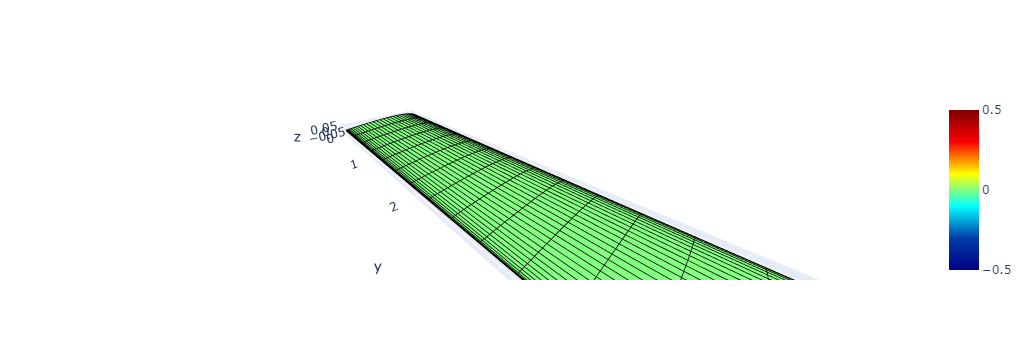

In [20]:
wing.draw(backend="plotly",show_kwargs={'colorscale':"jet"})
print()